# Decision Tree
Decision Trees (DTs) are a non-parametric supervised learning method used for classification. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

## Instruction to Use
1. load data from Github. 
2. run `main`
3. run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` in terminal.
4. run `showTreeImg` to visualize the tree.

## Input 

1. .csv - produced by `pre_processing.ipynb`
2. The pre_processed input data includes following techniques:
   * MinMax Scaling
   * PCA
   * Correlation

## Output
1. dot file `images/decisionTree.dot` of the decision tree.
2. run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` to generate png for the tree.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg

In [2]:
def showTreeImg():
    img = mpimg.imread('images/decisionTree.png')
    plt.imshow(img)
    plt.show()

In [3]:
def main(network_data):
    y = network_data['label']
    x = network_data.drop(['label'],axis=1)
    if 'attack_cat' in list(x):
        x = x.drop(['attack_cat'],axis=1)
    column_list = list(x)
    print("Shape of x: ", x.shape)
    print("Shape of y: ", y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    
    model = DecisionTreeClassifier(criterion='gini' ,max_depth=3, random_state = 0)
    model.fit(X_train, y_train)
    
    score = model.score(X_test, y_test)
    print("Score: ", score)
    
    predictions = model.predict(X_test)
    print(classification_report(y_test,predictions))
    
    export_graphviz(model, out_file = 'images/decisionTree.dot', feature_names=column_list )

We also drop 'attack_cat' because there is only one encoded digit for non-attack category.
## Classification without Preprocessing

In [13]:
network_data = pd.read_csv('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/2.Data_Cleaning/cleaned_dataset_label_encoding.csv')
main(network_data)

Shape of x:  (257673, 42)
Shape of y:  (257673,)
Score:  0.8908825127422317
              precision    recall  f1-score   support

           0       0.81      0.90      0.86     27719
           1       0.94      0.89      0.91     49583

    accuracy                           0.89     77302
   macro avg       0.88      0.89      0.88     77302
weighted avg       0.90      0.89      0.89     77302



run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` in terminal to generate png.

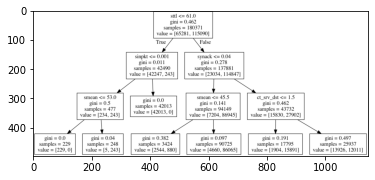

In [14]:
showTreeImg()

## Classification with RF after MinMax Scaling 

In [6]:
network_data = pd.read_csv('https://media.githubusercontent.com/media/divyaKh/CMPE255Project/main/4.Preprocessing/data_minmax_labelenc.csv')
main(network_data)

Shape of x:  (257673, 42)
Shape of y:  (257673,)
Score:  0.8895112674963132
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     27904
           1       0.94      0.88      0.91     49398

    accuracy                           0.89     77302
   macro avg       0.88      0.89      0.88     77302
weighted avg       0.89      0.89      0.89     77302



run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` in terminal to generate png.

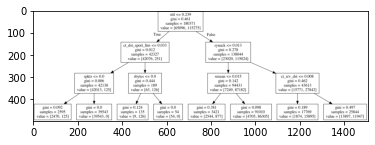

In [7]:
showTreeImg()

## Classification with RF after MinMax Scaling + Dimension Reduction (using PCA)

In [8]:
network_data = pd.read_csv('https://media.githubusercontent.com/media/divyaKh/CMPE255Project/main/4.Preprocessing/dataset_pca.csv')
main(network_data)

Shape of x:  (257673, 29)
Shape of y:  (257673,)
Score:  0.875320172828646
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     27844
           1       0.85      0.99      0.91     49458

    accuracy                           0.88     77302
   macro avg       0.90      0.83      0.85     77302
weighted avg       0.89      0.88      0.87     77302



run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` in terminal to generate png.

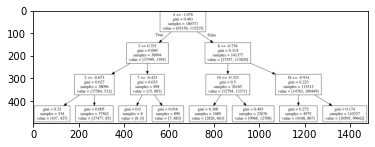

In [9]:
showTreeImg()

## Classification with RF after MinMax Scaling + Correlation analysis

In [10]:
network_data = pd.read_csv('https://media.githubusercontent.com/media/divyaKh/CMPE255Project/main/4.Preprocessing/dataset_minmax_corr.csv')
main(network_data)

Shape of x:  (257673, 39)
Shape of y:  (257673,)
Score:  0.8913740912266177
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     27731
           1       0.94      0.89      0.91     49571

    accuracy                           0.89     77302
   macro avg       0.88      0.89      0.88     77302
weighted avg       0.90      0.89      0.89     77302



run `dot -Tpng images/decisionTree.dot -o images/decisionTree.png` in terminal to generate png.

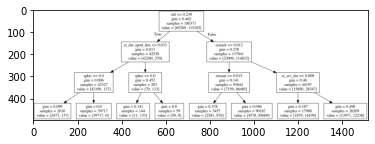

In [11]:
showTreeImg()